In [3]:
from datasets import load_dataset
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np

In [4]:
third_set = pd.read_csv('../data/generated_data/jokes_third_set.csv')

In [5]:
third_set

,joke,body,punchline,score,date
0,A Day in Court,NaN,A Day in Court,5.0,1.201282e+09
1,Photograph of Software project Team,NaN,Photograph of Software project Team,0.0,1.202643e+09
2,what we guys really like,NaN,what we guys really like,3.0,1.202651e+09
3,The Nietzsche Family Circus random generator,NaN,The Nietzsche Family Circus random generator,3.0,1.204249e+09
4,funny pic: His & Hers SUV,NaN,funny pic: His & Hers SUV,0.0,1.206129e+09
...,...,...,...,...,...
573403,A German joke A German is driving his car in B...,A German is driving his car in Britain. A Brit...,A German joke,16.0,1.577835e+09
573404,My wife has asked me to help her with her diet...,So I've hidden her teeth!,My wife has asked me to help her with her diet...,4.0,1.577835e+09
573405,Me arguing with my dad Me: I hate you motherfu...,Me: I hate you motherfucker\nMy dad: That’s th...,Me arguing with my dad,2.0,1.577836e+09
573406,"Early I know it's early, but a very happy new ...","I know it's early, but a very happy new year f...",Early,21.0,1.577836e+09


In [6]:
third_set.isnull().sum()

joke            6
body         5767
punchline      73
score          73
date          112
dtype: int64

In [7]:

third_set_clean = third_set[['body','punchline','score']]


mask = (
    third_set_clean['body'].isna() |
    third_set_clean['punchline'].isna() |
    third_set_clean['score'].isna()
)


third_set_clean = third_set_clean[~mask].reset_index(drop=True)


In [8]:
third_set_clean['body'].value_counts()

body
Dr. Dre                                                                                134
To get to the other side.                                                              126
A stick.                                                                                95
None.                                                                                   95
He worked it out with a pencil.                                                         84
                                                                                      ... 
He wrote, "i is the square root of negative 1."                                          1
Those who know binary, those who don't, and those who knew this was a trinary joke.      1
Because they are always multiplying.                                                     1
"Tell that to Albert Einstein."                                                          1
... And con? That's an American word....                                             

In [9]:
third_set_clean = third_set_clean[third_set_clean['score'] >= 5]

In [10]:
import re
import pandas as pd

def normalize_for_dedup(text: str) -> str:
    """
    Aggressive normalization for comparison only:
    - lowercase
    - remove ALL non-word characters (punctuation, spaces, tabs, newlines, etc.)
    """
    if pd.isna(text):
        return ""
    t = str(text).lower()
    
    t = re.sub(r"\\[nrt]", "", t)
    # keep only letters, digits and underscore; drop everything else
    t = re.sub(r"\W+", "", t, flags=re.UNICODE)
    return t


In [11]:
META_KEYWORDS = [
    "credit", "thanks for", "thanks to",
    "crosspost", "x-post", "xpost",
    "translated from", "heard this joke",
    "from my favourite", "from my favorite",
    "from the sopranos", "from my dad", "told to me by",
    "sorry for the formatting", "on mobile",
    "first post", "oc", "original content",
    "upvote", "downvote", "karma",
    "reddit.com", "r/", "/r/",
    "nsfw", "trigger warning", "spoiler",
    "feel free to", "please comment",
]

def strip_intrusive_tail(text: str) -> str:
    """Remove EDIT blocks, credits, and meta tails from the *end* of a joke."""
    if not isinstance(text, str) or not text:
        return text
    t = text

    # 1) Cut everything from the first "\n\nEDIT" (or "\\n\\nEDIT") to the end
    m = re.search(r'(?:\n\n|\\n\\n)\s*edit\b', t, flags=re.IGNORECASE)
    if m:
        t = t[:m.start()].rstrip()

    # 2) Drop a trailing URL
    t = re.sub(r'\s*https?://\S+\s*$', "", t, flags=re.IGNORECASE)

    # 3) Trailing parentheses with meta keywords or person-like name
    m = re.search(r'\(([^()]*)\)\s*$', t, flags=re.UNICODE)
    if m:
        tail = m.group(1).strip()
        tail_lower = tail.lower()

        has_meta = any(k in tail_lower for k in META_KEYWORDS)
        has_name = re.search(r'\b[A-Z][a-z]{2,}\s+[A-Z][a-z]{2,}\b', tail)

        if has_meta or has_name:
            # cut off the whole "(...)" part
            t = t[:m.start()].rstrip()

    # 4) Credits after a dash at the end: '"... joke ..." - Name, 2018'
    t = re.sub(
        r'\s*[-–—]\s*(?:by\s+)?(?:[A-Z][a-z]{2,}\s+){1,3}[A-Z][a-z]{2,}(?:\s*,\s*\d{4})?\s*$',
        "",
        t,
        flags=re.UNICODE,
    ).rstrip()

    # 5) Meta keywords very near the end: cut from keyword to end
    tail_span = 120
    if len(t) <= tail_span:
        start = 0
    else:
        start = len(t) - tail_span

    search_region = t[start:].lower()
    first_pos = None
    for kw in META_KEYWORDS:
        pos = search_region.find(kw)
        if pos != -1:
            abs_pos = start + pos
            if first_pos is None or abs_pos < first_pos:
                first_pos = abs_pos

    if first_pos is not None:
        t = t[:first_pos].rstrip()

    return t


In [12]:
df = third_set_clean.copy()

# fill NaNs and convert to string
for col in ["body", "punchline"]:
    df[col] = df[col].fillna("").astype(str)
    # strip intrusive tails first
    df[col] = df[col].map(strip_intrusive_tail)

# now normalize for dedup on the *cleaned* text
df["body_norm"]    = df["body"].map(normalize_for_dedup)
df["punchline_norm"] = df["punchline"].map(normalize_for_dedup)

df["cluster_key"] = df["body_norm"] + " || " + df["punchline_norm"]



In [13]:
def keep_central_score_median(group: pd.DataFrame) -> pd.DataFrame:
    # median score of this cluster
    target = group["score"].median()
    # index of row closest to median
    idx = (group["score"] - target).abs().idxmin()
    return group.loc[[idx]]  # keep it as a DataFrame

df_dedup = (
    df
    .groupby("cluster_key", group_keys=False)
    .apply(keep_central_score_median)
    .reset_index(drop=True)
)

# drop helper columns
df_dedup = df_dedup.drop(columns=["body_norm", "punchline_norm", "cluster_key"])

print("Original:", len(df), "rows")
print("Deduped :", len(df_dedup), "rows")


Original: 297469 rows
Deduped : 272877 rows


/var/folders/2q/qf84z8xs67vfwjt96dblpb9c0000gn/T/ipykernel_7005/1083906026.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


In [14]:
third_set_dpo = df_dedup.copy()

In [15]:
third_set_dpo

,body,punchline,score
0,,,7.0
1,...,A baby seal walks into a club...,23.0
2,,A big shout out to sidewalks!,8.0
3,,"According to FBI, the number of serial killers...",85.0
4,,"Actually, violent video games don’t create vio...",5.0
...,...,...,...
272872,"Ой, подождите, извините, это только для нас, р...",United States 2020 Election results are in!,33.0
272873,אחי היה לי כלכך חם שהבטחתי שאם יציעו לי להתנצר...,Jewish Joke About Warm Weather,6.0
272874,ಠ_ಠ,A seal walks into a club...,20.0
272875,ಠ_ಠ,So a baby seal walks into a club...,5.0


In [16]:
third_set_dpo = third_set_dpo.rename(columns={
    "body": "setup",          
    "punchline": "punchline",   
})

third_set_dpo["setup"] = third_set_dpo["setup"].fillna("").str.strip()
third_set_dpo["punchline"] = third_set_dpo["punchline"].fillna("").str.strip()
third_set_dpo = third_set_dpo[(third_set_dpo["setup"] != "") & (third_set_dpo["punchline"] != "")]

In [17]:
def normalize_setup(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

third_set_dpo["setup_norm"] = third_set_dpo["setup"].map(normalize_setup)


In [18]:
def best_vs_worst(group: pd.DataFrame):
    if len(group) < 2:
        return None

    hi = group.loc[group["score"].idxmax()]
    lo = group.loc[group["score"].idxmin()]

    # Skip if scores are identical
    if hi["score"] == lo["score"]:
        return None

    return pd.Series({
        "setup": hi["setup"],
        "chosen_punchline": hi["punchline"],
        "rejected_punchline": lo["punchline"],
        "chosen_score": hi["score"],
        "rejected_score": lo["score"],
    })




In [19]:
pairs_df = (
    third_set_dpo.groupby("setup_norm", group_keys=False)
      .apply(best_vs_worst)
      .dropna()
      .reset_index(drop=True)
)

print("Number of preference pairs:", len(pairs_df))

Number of preference pairs: 10700


/var/folders/2q/qf84z8xs67vfwjt96dblpb9c0000gn/T/ipykernel_7005/2282876774.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  third_set_dpo.groupby("setup_norm", group_keys=False)


In [20]:
pairs_df

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,"""",A father in Iraq gifted his daughter a new bag...,What is Trump's favorite movie?,35940.0,5.0
1,""" there is one thing I've always wanted to kno...",A lady dies and goes to heaven and is standing...,"A lady died and went to heaven, upon seeing Go...",2942.0,59.0
2,"""...so technically officer, this is YOUR marij...","""Whoever smelt it, dealt it...""","""Whoever smeal it, dealt it""...",2007.0,43.0
3,"""1, 2, 3, 3.1, 95, 98, ME, 2000, XP, Vista, 7,...",Bill Gates teaches a kindergarten class to cou...,Bill Gates recently visited a kindergarten and...,10469.0,85.0
4,"""A man has been arrested after half a million ...",I was watching the news this morning when the ...,I was watching the news this morning when th p...,18907.0,9.0
...,...,...,...,...,...
10695,"“You da bomb!”\n\n“No, you da bomb!”\n\nIn Ame...",The difference.,“You da bomb!”,160.0,41.0
10696,"“You know, one would have been enough.”","As I handed my Dad his 50th birthday card, he ...","As I handed my dad his 60th birthday card, he ...",466.0,136.0
10697,“You’re much bigger than that.”,"My wife just told me, “Don’t get upset when so...","My wife just told me, “Don’t take it personall...",42.0,15.0
10698,“You’ve got a friend in me”,What did Bo Peep say when Woody walked in on h...,What did Andy’s girlfriend say to him when she...,17.0,5.0


In [21]:
import re
import pandas as pd

def is_meta_only_setup(text: str) -> bool:
    """Return True if the whole setup is just TL;DR, NSFW label, link, etc."""
    if not isinstance(text, str):
        return True  # treat NaN as bad
    t = text.strip()
    if not t:
        return True

    # TL;DR only (variants: tl;dr, tl:dr:, etc.)
    if re.fullmatch(r'(?i)tl;?\s*dr:?', t):
        return True

    # NSFW labels only: "NSFW", "[NSFW]", "(nsfw)" etc.
    if re.fullmatch(r'(?i)[\[\(]*\s*nsfw\s*[\]\)]*', t):
        return True

    # bare http / https or www link
    if re.fullmatch(r'(https?://\S+|www\.\S+)', t, flags=re.IGNORECASE):
        return True

    # bare subreddit or similar: "r/funny"
    if re.fullmatch(r'(?i)r/\S+', t):
        return True

    return False


def apply_setup_filters(df: pd.DataFrame,
                        min_chars: int = 3,
                        max_chars: int = 512) -> pd.DataFrame:
    s = df["setup"].fillna("")

    # 1) meta-only setups
    mask_meta = s.apply(is_meta_only_setup)

    # 2) too long setups
    mask_long = s.str.len() > max_chars

    # 3) too short / only punctuation setups
    #    remove all non-alphanumeric characters and see what is left
    alnum = s.str.replace(r"[^0-9A-Za-z]+", "", regex=True)
    mask_short = alnum.str.len() < min_chars

    mask_drop = mask_meta | mask_long | mask_short

    print("Total rows:", len(df))
    print("  meta-only setups dropped :", mask_meta.sum())
    print("  too long setups dropped   :", mask_long.sum())
    print("  too short / punct. dropped:", mask_short.sum())
    print("  total dropped             :", mask_drop.sum())

    return df[~mask_drop].reset_index(drop=True)


In [22]:
pairs_df = apply_setup_filters(pairs_df, min_chars=3, max_chars=256)

Total rows: 10700
  meta-only setups dropped : 2
  too long setups dropped   : 1260
  too short / punct. dropped: 90
  total dropped             : 1352


In [23]:
#pairs_df.to_csv("third_set_dpo.csv", index=False)
pairs_df

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,"""...so technically officer, this is YOUR marij...","""Whoever smelt it, dealt it...""","""Whoever smeal it, dealt it""...",2007.0,43.0
1,"""1, 2, 3, 3.1, 95, 98, ME, 2000, XP, Vista, 7,...",Bill Gates teaches a kindergarten class to cou...,Bill Gates recently visited a kindergarten and...,10469.0,85.0
2,"""A man has been arrested after half a million ...",I was watching the news this morning when the ...,I was watching the news this morning when th p...,18907.0,9.0
3,"""And then things got worse.""",Russian history in 5 words:,Chinese history in 5 words:,8021.0,20.0
4,"""Are you going to eat that?""",What did Jeffrey Dahmer say to Lorena Bobbitt?,What did Jeffrey Dahmer say to Lorena Bobbit?,8.0,5.0
...,...,...,...,...,...
9343,“You are much bigger than that.”,"My wife said to me, “Don’t take it personally ...","My wife told me, “Don’t get upset if your frie...",236.0,12.0
9344,"“You da bomb!”\n\n“No, you da bomb!”\n\nIn Ame...",The difference.,“You da bomb!”,160.0,41.0
9345,"“You know, one would have been enough.”","As I handed my Dad his 50th birthday card, he ...","As I handed my dad his 60th birthday card, he ...",466.0,136.0
9346,“You’re much bigger than that.”,"My wife just told me, “Don’t get upset when so...","My wife just told me, “Don’t take it personall...",42.0,15.0


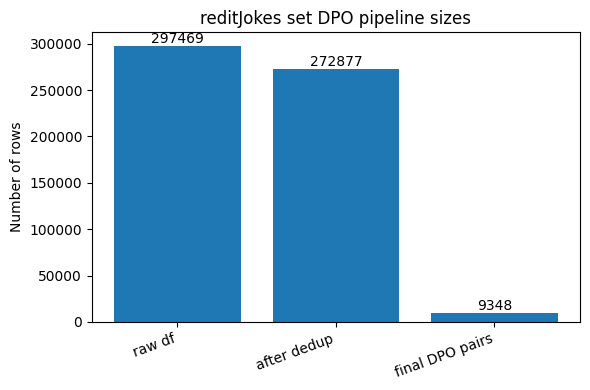

In [24]:
import matplotlib.pyplot as plt

stage_names = ["raw df", "after dedup", "final DPO pairs"]
counts = [len(df), len(df_dedup), len(pairs_df)]

plt.figure(figsize=(6, 4))
plt.bar(stage_names, counts)
plt.title("reditJokes set DPO pipeline sizes")
plt.ylabel("Number of rows")
plt.xticks(rotation=20, ha="right")

for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()
